## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

## Load Data

In [3]:
data = pd.read_csv('../data/final_dataset.csv')

In [4]:
# Display first 5 rows
data.head()

,title,selftext,subreddit,is_bitcoin,title_clean,selftext_clean,title_length,selftext_length,more_text_clean,final_text_clean
0,"Crypto Influencers Dorsey, Woods, and Musk Fac...",emptypost,Bitcoin,1,"['crypto', 'influencers', 'dorsey', 'wood', 'm...",['emptypost'],8,1,"['influencers', 'dorsey', 'wood', 'musk', 'fac...","['influencers', 'dorsey', 'wood', 'musk', 'fac..."
1,Elon Musk’s View on Bitcoin (July 21 2021),emptypost,Bitcoin,1,"['elon', 'musk', 'view', 'bitcoin', 'july', '2...",['emptypost'],7,1,"['elon', 'musk', 'view', 'bitcoin', 'july', '2...","['elon', 'musk', 'view', 'bitcoin', 'july', '21']"
2,best crypto video ive ever watched,emptypost,Bitcoin,1,"['best', 'crypto', 'video', 'ive', 'ever', 'wa...",['emptypost'],6,1,"['best', 'video', 'ive', 'ever', 'watched', 'e...","['best', 'video', 'ive', 'ever', 'watched']"
3,what moves crypto market apart from the specul...,I would like to know if there is anything tha...,Bitcoin,1,"['move', 'crypto', 'market', 'apart', 'specula...","['', 'would', 'like', 'know', 'anything', 'mov...",5,14,"['move', 'market', 'apart', 'speculator', '', ...","['move', 'market', 'apart', 'speculator', '', ..."
4,Help starting crypto business,Hi guys.\n\nI'm interested in starting a crypt...,Bitcoin,1,"['help', 'starting', 'crypto', 'business']","['hi', 'guy', 'im', 'interested', 'starting', ...",4,48,"['help', 'starting', 'business', 'hi', 'guy', ...","['help', 'starting', 'business', 'hi', 'guy', ..."


In [5]:
# Check for missing value and data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2786 non-null   object
 1   selftext          2786 non-null   object
 2   subreddit         2786 non-null   object
 3   is_bitcoin        2786 non-null   int64 
 4   title_clean       2786 non-null   object
 5   selftext_clean    2786 non-null   object
 6   title_length      2786 non-null   int64 
 7   selftext_length   2786 non-null   int64 
 8   more_text_clean   2786 non-null   object
 9   final_text_clean  2786 non-null   object
dtypes: int64(3), object(7)
memory usage: 217.8+ KB


## 3. Modelling and Evaluation

In this section, we will first establish the baseline model using the Zero Rate (ZeroR) classifier. Next, we will train, test, and optimize (through hyperparameters tuning) two models, namely Naive Bayes Multinomial model and Linear Support Vector Machine. We will then evaluate the models against the baseline model and compare the two models before making a recommendation.

### 3.1 Establish baseline model

We will be using the Zero Rate (ZeroR) classifier as the baseline model. ZeroR classifier always classifies predictions to the most frequent class. To contextualize to our project, the most frequent class in our dataset is the Bitcoin subreddit (i.e a value of '1' in the is_bitcoin column). In a binary classification problem, ZeroR is more often than not correct by just going with the odds. For our models to demonstrate that they have skill on a problem, they must achieve an accuracy better than this ZeroR value.

In [6]:
# Establish baseline score
zeroR_score = round(data['is_bitcoin'].mean(),4) * 100
print(f'Our model should beat the baseline accuracy score of {zeroR_score}%.')

Our model should beat the baseline accuracy score of 65.0%.


In [7]:
X = data['final_text_clean']
y = data['is_bitcoin']

0       1
1       1
2       1
3       1
4       1
       ..
2781    0
2782    0
2783    0
2784    0
2785    0
Name: is_bitcoin, Length: 2786, dtype: int64

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    random_state=42,
                                                    stratify=y)

### 3.2 Naive Bayes Multinomial Model

MultinomialNB is an appropriate choice for Naive Bayes modelling. The use of CountVectorizer allows us to transform X into columns containing integer value.

In [10]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

cvec_multinb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [11]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check through ngram_range

cvec_multinb_pipe_params = {
                            'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
                            'cvec__min_df': [2, 3],
                            'cvec__max_df': [.9, .95],
                            'cvec__ngram_range': [(1,1), (1,2), (2,2),(2,3),(3,3)]
}

In [12]:
# Instantiate GridSearchCV.

cvec_multinb_gs = GridSearchCV(cvec_multinb_pipe, 
                  param_grid=cvec_multinb_pipe_params, 
                  cv=5) # 5-fold cross-validation.


In [13]:
# Fit GridSearch to training data.
cvec_multinb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3),
                                               (3, 3)]})

In [14]:
# Determine optimal set of hyperparameters
cvec_multinb_gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [15]:
cvec_multinb_gs_optimal = cvec_multinb_gs.best_estimator_

In [16]:
# Score model on training set.
cvec_multinb_gs_optimal.score(X_train, y_train)

0.9104972375690608

In [17]:
# Score model on testing set.
cvec_multinb_gs_optimal.score(X_test, y_test)

0.8586065573770492

In [18]:
# Generate our predictions!
multinb_predictions = cvec_multinb_gs_optimal.predict(X_test)

In [19]:
multinb_predictions.shape

(976,)

In [20]:
cvec_multinb_gs_optimal

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=2)),
                ('nb', MultinomialNB())])

In [21]:
# define function to create confusion matrix and classification report
def make_cm(model, X, y, names):
    
    # get predictions from the model and plot the against the actual values in a confusion matrix
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    # convert confusion matrix to dataframe
    cols = ['pred_' + c for c in names]
    dfcm = pd.DataFrame(cm, columns=cols, index=names)
    
    # print confusion matrix and classification report
    print(dfcm)
    print("--------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    
    # credit adi brohstein for the basis for this code

In [22]:
# run confusion matrix function
make_cm(cvec_multinb_gs_optimal, X_test, y_test, ['actual_r/Ethereum','actual_r/Bitcoin'])

                   pred_actual_r/Ethereum  pred_actual_r/Bitcoin
actual_r/Ethereum                     239                    103
actual_r/Bitcoin                       35                    599
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.70      0.78       342
           1       0.85      0.94      0.90       634

    accuracy                           0.86       976
   macro avg       0.86      0.82      0.84       976
weighted avg       0.86      0.86      0.85       976



In [23]:
# Generate a confusion matrix.
confusion_matrix(y_test, multinb_predictions)

array([[239, 103],
       [ 35, 599]], dtype=int64)

In [24]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, multinb_predictions).ravel()

In [25]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 239
False Positives: 103
False Negatives: 35
True Positives: 599


### 3.3 Linear Support Vector Machine

With a relatively high features to row ratio and a binary target variable, we used a Linear Support Vector Machine in attempt to generate exceptional model performance (i.e. high accuracy).

In [26]:
# Train/test split again
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    random_state=42,
                                                    stratify=y)

In [27]:
# instantiate TF-IDF and SVC pipeline
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(kernel='linear', gamma='auto'))
])

In [28]:
# define parameter grid for SVC model
svm_params = {
    'tfidf__max_features': [1_000, 2_000, 3_000, 4_000,5_000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': [None, 'english'],
    'svc__C': [0.1, 1, 10, 100]
}

In [29]:
# griseach through hyperparameters for SVC model
svm_gs = GridSearchCV(svm_pipe, param_grid=svm_params, cv=5, n_jobs=-1)
svm_gs.fit(X_train, y_train)

# display best hyperparameters
svm_gs.best_params_

{'svc__C': 1,
 'tfidf__max_features': 3000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': None}

In [30]:
svm_gs_optimal = svm_gs.best_estimator_

In [31]:
# Score model on training data
svm_gs_optimal.score(X_train, y_train)

0.961878453038674

In [32]:
# Score model on testing data
svm_gs_optimal.score(X_test, y_test)

0.8586065573770492

In [33]:
# run confusion matrix function
make_cm(svm_gs_optimal, X_test, y_test, ['r/Ethereum','r/Bitcoin',]) 

            pred_r/Ethereum  pred_r/Bitcoin
r/Ethereum              246              96
r/Bitcoin                42             592
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       342
           1       0.86      0.93      0.90       634

    accuracy                           0.86       976
   macro avg       0.86      0.83      0.84       976
weighted avg       0.86      0.86      0.86       976



### 3.4 Model evaluation and recommendation

On testing, both Naive Bayes (NB) Multinomial model and Linear Support Vector Machine (SVM) coincidentally scored an accuracy of 85.9% and outpeformed the baseline model's accuracy of 65.0%. While both NB Multinomial model and Linear SVM are overfitted (since training accuracy > testing accuracy), the extent of overfitting is lower in NB Multinomial model. This is evident by the smaller gap between training accuracy and testing accuracy in NB Multinomial model. We expect NB Multinomial model would be more stable than Linear SVM when exposed to unseen text data. We believe that the greater stability in NB Multinomial model would outweigh the effects of marignal lower accuracy when compared to Linear SVM. To top it off, NB Multinomial model allows us to study the significance of predictors in our text features but Linear SVM does not. Therefore, we recommend that NB Multinomial model would be suitable than Linear SVM to be used as the classifier in the development of the minimum viable product for the chatbot.

### 3.5 Visualizations and Analysis of Optimal Naive Bayes Model with Count Vectorizer

In [34]:
# run the Count Vectorized model with the optimal hyperparameters
cvec = CountVectorizer(ngram_range=(1, 1),  max_features=3000, max_df=0.9, min_df =2)
train_raw = cvec.fit_transform(X_train)
train_df = pd.DataFrame(train_raw.toarray(), columns=cvec.get_feature_names())

test_raw = cvec.transform(X_test)
test_df = pd.DataFrame(test_raw.toarray(), columns=cvec.get_feature_names())

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# fit the multinomail NB model
cvec_nb = MultinomialNB()
cvec_nb.fit(train_df, y_train)

MultinomialNB()

In [35]:
# fit the multinomail NB model
cvec_nb = MultinomialNB()
cvec_nb.fit(train_df, y_train)

MultinomialNB()

In [36]:
# score 
cvec_nb.score(test_raw, y_test)

0.8514344262295082

In [37]:
# define fucntion to determine the most useful features for  Multinomial NB classifiers
def nb_features(vectorizer, classifier, n=20, class_labels=[0, 1]):
    
    # get list of feature names from the vectorizor
    feature_names = vectorizer.get_feature_names()
    
    # two lists of tuples that contain the log probability from the classifier
    # tie it to the corresponding feature names, sort the list by highest log probability
    top_class0 = sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:n]
    top_class1 = sorted(zip(classifier.feature_log_prob_[1], feature_names), reverse=True)[:n]
    # credit to Sai Sandeep on StackOverflow for giving the basis for the zip method of tying names and counts together
    
    print(f"Important words in classifying posts for {class_labels[0]}")
    
    # print label, the exponential of the log probability,  and the feature names
    for prob, feat in top_class0:
        print(class_labels[0], np.exp(prob), feat)

    print(" ")
    print(" ")
    print(f"Important words in classifying posts for {class_labels[1]}")

    for prob, feat in top_class1:
        print(class_labels[1], np.exp(prob), feat)

In [38]:
# create dataframes for plotting NB results
# note that exponential is taken from the log probability to get the actual probability for each feature
nb_feat_importance_btc = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[0]), train_df.columns, columns=['probability'])
nb_feat_importance_eth = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[1]), train_df.columns, columns=['probability'])

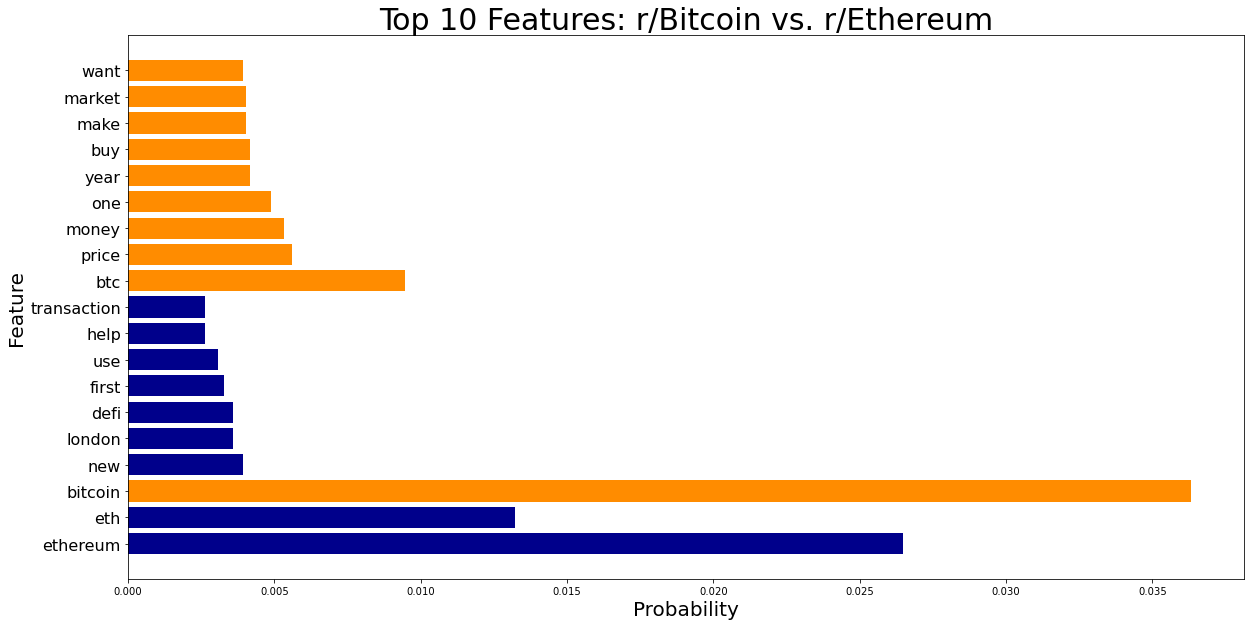

In [39]:
# plot the results from the NB dataframes
plt.figure(figsize=(20,10))
eth = nb_feat_importance_btc.sort_values('probability', ascending=False).head(10)
btc = nb_feat_importance_eth.sort_values('probability', ascending=False).head(10)

plt.barh(eth.index, eth['probability'], color='darkblue')
plt.barh(btc.index, btc['probability'], color='darkorange')
plt.yticks(size=16)

plt.title('Top 10 Features: r/Bitcoin vs. r/Ethereum', fontsize=30)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Feature', fontsize=20);

Looking at the top 10 features in r/Bitcoin (represented by orange bars), it is no wonder that 'bitcoin and 'btc' came up as the top features. Based on our domain knowledge, the rest of the top features does not seem to have any association or linked to Bitcoin. 

Looking at the top 10 features in r/Ethereum (represented by blue bars), it is no wonder that 'ethereum and 'eth' came  as the top features. Another word that is specific to Ethereum is 'defi' which stands for decentralized finance. It refers to a collective term for financial products and services that are accessing to anyone who can use Ethereum.

In [40]:
nb_features(cvec, cvec_nb, class_labels=['r/Ethereum', 'r/Bitcoin'])

Important words in classifying posts for r/Ethereum
r/Ethereum 0.02647183396865735 ethereum
r/Ethereum 0.013235916984328687 eth
r/Ethereum 0.004870817450232955 bitcoin
r/Ethereum 0.003917831427361287 new
r/Ethereum 0.003600169419737402 london
r/Ethereum 0.003600169419737402 defi
r/Ethereum 0.003282507412113513 first
r/Ethereum 0.0030707327403642556 use
r/Ethereum 0.002647183396865737 transaction
r/Ethereum 0.002647183396865737 price
r/Ethereum 0.002647183396865737 help
r/Ethereum 0.002541296060991106 go
r/Ethereum 0.002541296060991106 cryptocurrency
r/Ethereum 0.002541296060991106 blockchain
r/Ethereum 0.0024354087251164773 token
r/Ethereum 0.0024354087251164773 one
r/Ethereum 0.0024354087251164773 july
r/Ethereum 0.002329521389241848 upgrade
r/Ethereum 0.002329521389241848 exchange
r/Ethereum 0.002329521389241848 amp
 
 
Important words in classifying posts for r/Bitcoin
r/Bitcoin 0.03631117332800044 bitcoin
r/Bitcoin 0.009456332314373046 btc
r/Bitcoin 0.005599520041139325 price
r/Bit

#### Create plot confusion matrix function

In [41]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[239 103]
 [ 35 599]]


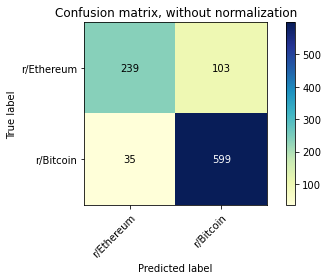

In [42]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['r/Ethereum','r/Bitcoin', ])

# generate predictions
cvec_multinb_gs_predictions = cvec_multinb_gs_optimal.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, cvec_multinb_gs_predictions , classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

## 4. Conclusion

The MVP chatbot should be piloted to a targeted group of users of our platform to determine if it is effective and productive in classifying and responding to text enquiries accurately. Building a custom model that combines NB model and SVM can deliver a more optimal performance. One potential future development is the expansion in the scope of our algorithm to include more cryptocurrencies by extending the existing binary classifiers to multi-class classifiers. Another potential development is use of sentiment analysis to augment our core text classification. With the productionization of our algorithm, it will be continuously trained through constant interaction with users. Given that a large proportion of our submissions contained non-text data such as links, video and image in their post, it can be useful to apply researach methods such as content analysis to apply and code these non-text documents and their associated texts. 